In [49]:
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
import torch
import torch.nn as nn
import torch.optim as optim

# import Python functions 
import sys

sys.path.append('../..')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [50]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

#### Select Validation data 

In [51]:
# Select desired pre-trained model 
while True:
    answer = input("Please provide experiment and runname (ex: E338, 12710) ").strip()
    if re.match('^E[0-9]+, [0-9]+', answer) is None:
        print("Invalid response, please try again")
        continue
    else: 
        experiment = re.match('^E[0-9]+', answer)[0]
        runname = re.search('[0-9]+$', answer)[0]
        try: 
            bs = np.load('../../data/processed/bunchSep' + experiment + '_' + runname + '.npy')
            predictor = np.load('../../data/processed/predictors' + experiment + '_' + runname + '.npy')
            # data_struct = mat['data_struct']
            print('Experiment loaded successfully.')
            break
        except FileNotFoundError: 
            print("Error: The specified data was not found in 'data/processed/'. Please run 'trainMLP_bunchSepMLP.py' and save processed data.")
            continue

Invalid response, please try again
Invalid response, please try again
Invalid response, please try again
Invalid response, please try again
Invalid response, please try again
Invalid response, please try again


#### Select Pre-Trained Model (BSA Vars need to match)

In [44]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, out_dim)
        )
    def forward(self, x):
        return self.model(x)

# Select desired pre-trained model 
while True:
    answer = input("Please provide experiment and runname (ex: E338, 12710) ").strip()
    if re.match('^E[0-9]+, [0-9]+', answer) is None:
        print("Invalid response, please try again")
        continue
    else: 
        experiment = re.match('^E[0-9]+', answer)[0]
        runname = re.search('[0-9]+$', answer)[0]
        try: 
            import joblib
            model = joblib.load('../../model/MLP_bunchSep_' + experiment + '_' + runname + '.pkl')
            x_scaler = joblib.load('../../model/scalers/' + experiment + '_' + runname + '_scaler.gz')
            print('Model loaded successfully.')
            break 
        except FileNotFoundError: 
            print("Error: The specified model was not found in 'model/'. Please run 'trainMLP_bunchSepMLP.py' and save model.")
            continue

Model loaded successfully.


/Users/siddhant/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/siddhant/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [48]:
model.predict(predictor)

ValueError: X has 131 features, but MLPRegressor is expecting 21 features as input.

In [46]:
model.eval()
with torch.no_grad():
    pred = model(predictor)

AttributeError: 'MLPRegressor' object has no attribute 'eval'

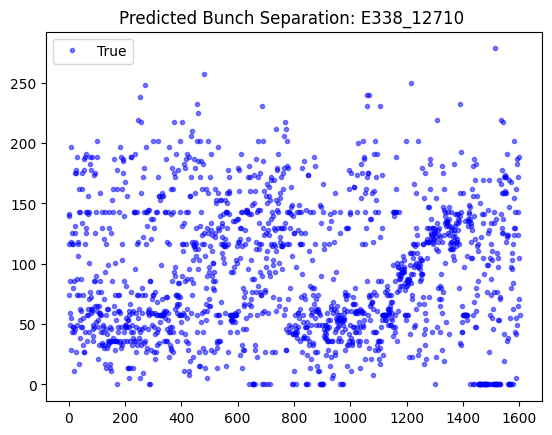

In [36]:
plt.plot(bs, 'b.', alpha = 0.5, label = "True")
plt.title(f"Predicted Bunch Separation: {experiment}_{runname} ")
plt.legend()